In [1]:
import pymc3 as pm
from pymc3 import model_to_graphviz, Continuous, Discrete
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import seaborn as sns
import arviz as az

In [16]:
import networkx as nx

In [5]:
from pymc3.theanof import floatX
import theano.tensor as tt

In [24]:
data = pd.read_csv("../data_raw/gene_summary.tsv", sep="\t")

In [20]:
frame = networkx.read_edgelist(
    "../data_raw/mouse_gene_network.tsv",
    delimiter="\t", data=(('weight',float),), nodetype=str)

/Users/simondi/miniconda3/envs/tix/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


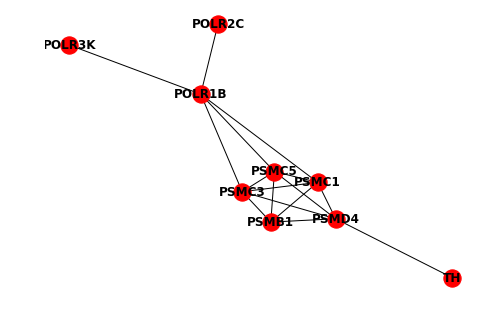

In [38]:
nx.draw(frame.subgraph(
    list(data.id.values[:4]) + 
    ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"]),
        with_labels=True, font_weight='bold');

In [72]:
type(G)

networkx.classes.graph.Graph

In [58]:
G = frame.subgraph(np.sort(list(data.id.values[:4]) + ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"]))

In [78]:
adj = nx.to_numpy_matrix(G, nodelist=np.sort(G.nodes()), weight='weight');

In [79]:
adj.dtype.names = np.sort(G.nodes())

ValueError: there are no fields defined

In [84]:
type(np.array(adj))

numpy.ndarray

/Users/simondi/miniconda3/envs/tix/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


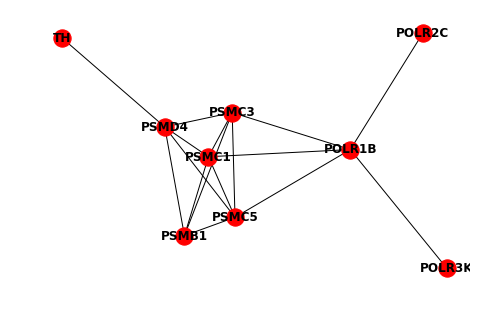

In [69]:
nodes = np.sort(G.nodes())
g = nx.from_numpy_array(adj)
nx.draw(g, font_weight='bold', 
        labels={n: nodes[n] for n in g.nodes()});

In [42]:
class Constant(Discrete):
    def __init__(self, G, node_labels = None, **kwargs):
        if isinstance(G, networkx.classes.graph.Graph):        
            self.__node_labels = np.sort(G.nodes())
            self.__adj = nx.to_numpy_matrix(G, nodelist=self.__node_labels, weight='weight')
        elif isinstance(G, networkx.classes.graph.Graph) or isinstance(G, numpy.ndarray):
            if node_labels is None:
                raise ValueError("Please provide node labels")
            self.__node_labels = node_labels
            self.__adj =  G                    
        super().__init__(**kwargs)

    def _markov_blank(self, idx):
        children = np.where(self.__adj[i, ] != 0)
        parents = np.where(self.__adj[, i] != 0)      
        return np.unique(np.concatenate(children, parents))


.edge.potential <- function(labels, x, adj)
{
  mb <- .markov.blanket(x, adj)

  sum((labels[mb] == labels[x]) * adj[mb, x]) -
    sum((labels[mb] != labels[x]) * adj[mb, x])
}


.energy <- function(a, labels, data, adj, theta)
{
  energy <- -log(LaplacesDemon::dinvgamma(a, 5, 1))
  for(i in seq(data))
  {
    if (labels[i] == 1) {
      energy <- energy - log(dbeta(data[i], a, 1))
    } else if (labels[i] == -1) {
      energy <- energy - log(dunif(data[i]))
    } else stop("what you doing, bra")

    energy <- energy + theta * .edge.potential(labels, i, adj)
  }

  energy
}
        
    def random(self, point=None, size=None):
        return 1
    
    def logp(self, value):
        return 0

In [43]:
with pm.Model() as model:
    A = Constant('A')
    B = pm.Normal('B', mu=20+A, sd=10)

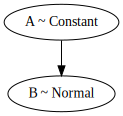

In [44]:
model_to_graphviz(model)

In [46]:
with model:
    pm.sample(1000, ninit=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [A]
>NUTS: [B]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3084.93draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


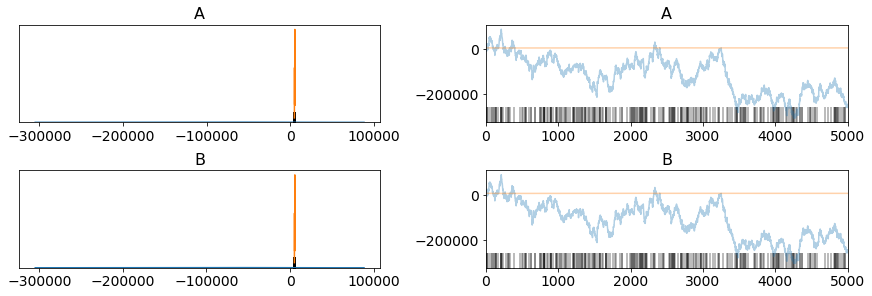

In [47]:
az.plot_trace(trace);